# Argüelles (Moncloa-Aravaca)

In [40]:
import json

import fiona
from fiona.transform import transform_geom
from ipyleaflet import GeoJSON, Map
from shapely.geometry import shape
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set()
# See https://stackoverflow.com/a/70000002/554319

In [2]:
with fiona.open("data/Barrios_20210712.shp") as src:
    src_crs = src.crs
    for record in src:
        if record["properties"]["NOMBRE"] == "Argüelles":
            neighbourhood_geom = transform_geom(
                src_crs, "epsg:4326", record["geometry"]
            )
            break

with fiona.open("data/Distritos_20210712.shp") as src:
    src_crs = src.crs
    for record in src:
        if record["properties"]["NOMBRE"] == "Moncloa - Aravaca":
            district_geom = transform_geom(src_crs, "epsg:4326", record["geometry"])
            break

In [3]:
m = Map()

m.add_layer(GeoJSON(data=district_geom))
m.add_layer(
    GeoJSON(
        data=neighbourhood_geom,
        style={"fillColor": "red"},
    )
)

# Somehow this ends up with a zoom level that is still too high
# minx, miny, maxx, maxy = shape(neighbourhood_geom).bounds
# m.fit_bounds([[miny, minx], [maxy, maxx]])
# Setting the zoom manually still doesn't cut it
# because there is a callback running,
# see https://github.com/davidbrochart/ipyleaflet/blob/66374717a5ea87b81c0fed8a8815e3b596073c0b/ipyleaflet/leaflet.py#L2241-L2280
# m.zoom = 16
m.center = shape(neighbourhood_geom).centroid.y, shape(neighbourhood_geom).centroid.x
m.zoom = 14

m

Map(center=[40.42820854189707, -3.7178463042498713], controls=(ZoomControl(options=['position', 'zoom_in_text'…

## Demografía

El barrio de Argüelles es el tercer barrio con mayor número de población del distrito, con 24,223 habitantes. En cuanto a la estructura de población por edades, destaca de forma muy considerable el grupo poblacional de 20 a 64 años con un total de 15292. La población infantil/joven cuenta con 3099 personas y de mayores de 65 años 5597, donde el grueso se concentra en la franja de 65 a 84 años. En cuanto a la población extranjera, Argüelles tiene 3353 habitantes de nacionalidad extranjera. 

In [4]:
import pandas as pd

In [5]:
df = pd.read_csv("data/Rango_Edades_Seccion_202111.csv", encoding="iso-8859-1", sep=";")
df["DESC_DISTRITO"] = df["DESC_DISTRITO"].str.strip()
df["DESC_BARRIO"] = df["DESC_BARRIO"].str.strip()
df.head()

,COD_DISTRITO,DESC_DISTRITO,COD_DIST_BARRIO,DESC_BARRIO,COD_BARRIO,COD_DIST_SECCION,COD_SECCION,COD_EDAD_INT,EspanolesHombres,EspanolesMujeres,ExtranjerosHombres,ExtranjerosMujeres
0,1,CENTRO,101,PALACIO,1,1001,1,0,2.0,3.0,1.0,NaN
1,1,CENTRO,101,PALACIO,1,1001,1,1,8.0,NaN,1.0,NaN
2,1,CENTRO,101,PALACIO,1,1001,1,2,1.0,3.0,NaN,5.0
3,1,CENTRO,101,PALACIO,1,1001,1,3,5.0,1.0,1.0,NaN
4,1,CENTRO,101,PALACIO,1,1001,1,4,NaN,NaN,NaN,3.0


In [6]:
district_pop = df.groupby("DESC_DISTRITO").sum().loc["MONCLOA-ARAVACA", "EspanolesHombres":"ExtranjerosMujeres"]
district_pop

EspanolesHombres      49908.0
EspanolesMujeres      57390.0
ExtranjerosHombres     5864.0
ExtranjerosMujeres     7916.0
Name: MONCLOA-ARAVACA, dtype: float64

In [9]:
district_pop.loc["Extranjeros":].sum()

13780.0

In [10]:
district_pop.sum()

121078.0

In [11]:
district_pop.loc["Extranjeros":].sum() / district_pop.sum()

0.11381093179603231

In [12]:
neighbourhood_pop = df.groupby("DESC_BARRIO").sum().loc["ARGUELLES", "EspanolesHombres":"ExtranjerosMujeres"]
neighbourhood_pop

EspanolesHombres       9469.0
EspanolesMujeres      11160.0
ExtranjerosHombres     1619.0
ExtranjerosMujeres     2088.0
Name: ARGUELLES, dtype: float64

In [13]:
neighbourhood_pop.loc["Extranjeros":].sum()

3707.0

In [14]:
neighbourhood_pop.sum()

24336.0

In [15]:
neighbourhood_pop.loc["Extranjeros":].sum() / neighbourhood_pop.sum()

0.15232577251808022

In [16]:
from pprint import pprint

In [17]:
DISTRICT_CODE = 9
NEIGHBOURHOOD_CODE = 92

In [18]:
district_records = []

with fiona.open("data/SECCION_CENSAL/POBLACION_SECCION.shp") as src:
    for record in src:
        if int(record["properties"]["COD_DIS"]) == DISTRICT_CODE:
            district_records.append(record)

In [19]:
print(sorted(list({int(r["properties"]["COD_BAR"]) for r in district_records})))


[91, 92, 93, 94, 95, 96, 97]


In [20]:
district_pop2 = pd.DataFrame([r["properties"] for r in district_records]).set_index("COD_SEC").sort_index()
district_pop2["COD_BAR"] = district_pop2["COD_BAR"].astype(int)
district_pop2["COD_DIS"] = district_pop2["COD_DIS"].astype(int)
district_pop2.head()

,COD_BAR,COD_DIS,ambos_sexo,ambos_se_1,ambos_se_2,ambos_se_3,ambos_se_4,ambos_se_5,ambos_se_6,ambos_se_7,...,ambos_s_14,ambos_s_15,ambos_s_16,ambos_s_17,ambos_s_18,ambos_s_19,ambos_s_20,ambos_s_21,Shape_STAr,Shape_STLe
COD_SEC,,,,,,,,,,,,,,,,,,,,,
09001,91,9,1182,39,32,26,32,56,89,90,...,70,37,50,45,54,36,10,3,8.802667e+04,1459.480585
09002,91,9,1314,42,36,33,124,54,96,90,...,40,39,59,58,59,26,8,0,1.561971e+07,17012.636439
09004,91,9,1472,37,42,36,60,75,91,102,...,78,58,37,63,75,28,8,3,6.519676e+04,1273.317385
09005,91,9,912,38,31,31,32,45,54,65,...,42,35,23,36,43,18,3,1,4.357138e+04,907.824350
09006,91,9,761,29,23,19,37,24,39,45,...,43,41,23,31,33,25,7,0,4.367297e+04,979.521205


In [21]:
total_district = district_pop2["ambos_sexo"].sum()
total_district

120834

In [22]:
total_neighbourhood = district_pop2.loc[district_pop2["COD_BAR"] == NEIGHBOURHOOD_CODE, "ambos_sexo"].sum()
total_neighbourhood

24162

---

In [23]:
district_records = []

with fiona.open("data/SECCION_CENSAL/POBLACION_HOMBRES_SECCION.shp") as src:
    for record in src:
        if int(record["properties"]["COD_DIS"]) == DISTRICT_CODE:
            district_records.append(record)

with fiona.open("data/SECCION_CENSAL/POBLACION_MUJERES_SECCION.shp") as src:
    for record in src:
        if int(record["properties"]["COD_DIS"]) == DISTRICT_CODE:
            district_records.append(record)

In [24]:
district_pop3 = pd.DataFrame([r["properties"] for r in district_records]).set_index("COD_SEC").sort_index()
district_pop3.head()

,COD_BAR,COD_DIS,hombres_to,hombres_00,hombres_05,hombres_10,hombres_15,hombres_20,hombres_25,hombres_30,...,mujeres_55,mujeres_60,mujeres_65,mujeres_70,mujeres_75,mujeres_80,mujeres_85,mujeres_90,mujeres_95,mujeres_11
COD_SEC,,,,,,,,,,,,,,,,,,,,,
09001,91,09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,59.0,35.0,40.0,19.0,27.0,38.0,39.0,29.0,7.0,2.0
09001,91,09,526.0,21.0,14.0,11.0,15.0,15.0,43.0,41.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09002,91,09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,62.0,44.0,21.0,30.0,37.0,36.0,43.0,19.0,6.0,0.0
09002,91,09,633.0,26.0,19.0,21.0,102.0,26.0,48.0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
09004,91,09,655.0,20.0,21.0,18.0,26.0,34.0,42.0,47.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
district_pop_melt = district_pop3.reset_index().melt(id_vars=["COD_SEC", "COD_BAR", "COD_DIS"]).sort_values("COD_SEC")
district_pop_melt.head()

,COD_SEC,COD_BAR,COD_DIS,variable,value
0,09001,91,09,hombres_to,NaN
1021,09001,91,09,hombres_25,43.0
6461,09001,91,09,mujeres_65,NaN
6460,09001,91,09,mujeres_65,40.0
1190,09001,91,09,hombres_30,NaN


In [26]:
district_pop_melt = district_pop_melt.loc[~district_pop_melt["variable"].str.contains("Shape")]
district_pop_melt

,COD_SEC,COD_BAR,COD_DIS,variable,value
0,09001,91,09,hombres_to,NaN
1021,09001,91,09,hombres_25,43.0
6461,09001,91,09,mujeres_65,NaN
6460,09001,91,09,mujeres_65,40.0
1190,09001,91,09,hombres_30,NaN
...,...,...,...,...,...
5438,09092,97,09,mujeres_30,NaN
5439,09092,97,09,mujeres_30,21.0
5608,09092,97,09,mujeres_35,NaN
5778,09092,97,09,mujeres_40,NaN


In [27]:
district_pop_melt["sex"] = district_pop_melt["variable"].str.split("_").str.get(0)

In [28]:
district_pop_melt["age"] = district_pop_melt["variable"].str.split("_").str.get(1)

In [29]:
district_pop_melt = district_pop_melt.drop(columns=["variable"])
district_pop_melt.head()

,COD_SEC,COD_BAR,COD_DIS,value,sex,age
0,09001,91,09,NaN,hombres,to
1021,09001,91,09,43.0,hombres,25
6461,09001,91,09,NaN,mujeres,65
6460,09001,91,09,40.0,mujeres,65
1190,09001,91,09,NaN,hombres,30


In [30]:
district_pop_melt = district_pop_melt.reset_index(drop=True)

In [31]:
district_pop_melt.loc[
    (district_pop_melt["COD_BAR"] == str(NEIGHBOURHOOD_CODE))
    & (district_pop_melt["sex"] == "hombres")
    & (district_pop_melt["age"] != "to")
].groupby("age")["value"].sum()

age
00    361.0
05    419.0
10    374.0
11      5.0
15    389.0
20    580.0
25    957.0
30    856.0
35    872.0
40    834.0
45    852.0
50    771.0
55    765.0
60    728.0
65    585.0
70    539.0
75    474.0
80    266.0
85    219.0
90    109.0
95     19.0
Name: value, dtype: float64

In [32]:
district_pop_melt.loc[
    (district_pop_melt["COD_DIS"].astype(int) == DISTRICT_CODE)
    & (district_pop_melt["sex"] == "hombres")
    & (district_pop_melt["age"] != "to")
].groupby("age")["value"].sum()

age
00    2465.0
05    2748.0
10    2882.0
11      16.0
15    3254.0
20    3205.0
25    3649.0
30    3342.0
35    3745.0
40    4041.0
45    4163.0
50    4136.0
55    4061.0
60    3497.0
65    2777.0
70    2586.0
75    2072.0
80    1424.0
85    1002.0
90     437.0
95      86.0
Name: value, dtype: float64

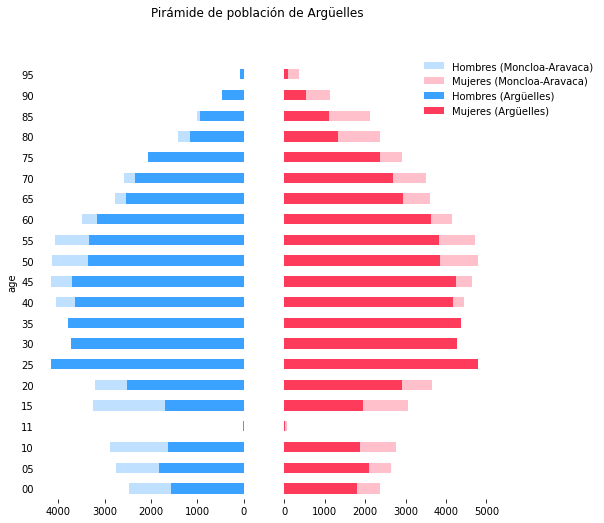

In [39]:
with plt.rc_context({
    "axes.spines.left": False,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.spines.bottom": False,
    "ytick.left": False,
}):
    fig, (ax_l, ax_r) = plt.subplots(figsize=(8, 8), ncols=2, sharey=True)

    district_pop_melt.loc[
        (district_pop_melt["COD_DIS"].astype(int) == DISTRICT_CODE)
        & (district_pop_melt["sex"] == "hombres")
        & (district_pop_melt["age"] != "to")
    ].groupby("age")["value"].sum().plot.barh(ax=ax_l, color="#BFE1FF", label="Hombres (Moncloa-Aravaca)")
    ax_l.invert_xaxis()
    ax_l.set_facecolor("none")

    ax_l2 = ax_l.twiny()
    district_pop_melt.loc[
        (district_pop_melt["COD_BAR"] == str(NEIGHBOURHOOD_CODE))
        & (district_pop_melt["sex"] == "hombres")
        & (district_pop_melt["age"] != "to")
    ].groupby("age")["value"].sum().plot.barh(ax=ax_l2, color="#3BA3FF", label="Hombres (Argüelles)")
    ax_l2.invert_xaxis()
    ax_l2.set_axis_off()

    district_pop_melt.loc[
        (district_pop_melt["COD_DIS"].astype(int) == DISTRICT_CODE)
        & (district_pop_melt["sex"] == "mujeres")
        & (district_pop_melt["age"] != "to")
    ].groupby("age")["value"].sum().plot.barh(ax=ax_r, color="#ffc0cb", label="Mujeres (Moncloa-Aravaca)")
    ax_r.set_facecolor("none")

    ax_r2 = ax_r.twiny()
    district_pop_melt.loc[
        (district_pop_melt["COD_BAR"] == str(NEIGHBOURHOOD_CODE))
        & (district_pop_melt["sex"] == "hombres")
        & (district_pop_melt["age"] != "to")
    ].groupby("age")["value"].sum().plot.barh(ax=ax_r2, color="#FF3B5B", label="Mujeres (Argüelles)")
    ax_r2.set_axis_off()

    fig.legend(loc=1, bbox_to_anchor=(0.1, -0.1, 1, 1), facecolor="none", edgecolor="none")
    fig.suptitle("Pirámide de población de Argüelles")
    fig.subplots_adjust()

## Vivienda

El precio de la vivienda en Argüelles es el más alto del distrito, superando ampliamente la media del distrito. En cuanto al número de locales en el barrio también es considerablemente superior al del resto de barrios. 

## Nivel de estudios

En cuanto al nivel de estudios, destaca el número de personas con estudios superiores, universitarios que contrasta con un bajo número de personas con estudios inferiores o sin estudios. 

## Economía

El número de personas cotizantes antes de la pandemia (que prevemos ha debido de modificar sustancialmente estas cifras) es de 9244, de los cuales, 1828 serían autónomos, siendo el segundo barrio con mayor número de personas trabajando en este régimen. En cuanto a los sectores destaca, con amplia diferencia el sector servicios. Y en cuanto a las secciones destacan las de actividades profesionales, científicas y técnicas y el comercio al por mayor y al por menor. 

La estimación de la tasa absoluta de desempleo (antes de la pandemia) es de 4,8 frente a 5,2 de la media del distrito.  Concentrándose el número de en mayores de 35 y mayores de 45. De los desempleados registrados, más de un 25% serían de larga duración. 

## Política

En cuanto a los resultados electorales en las últimas municipales, Más Madrid fue la segunda fuerza más votada en el barrio, después del Partido Popular. Seguirían a Más Madrid, Ciudadanos, con alrededor de 1000 votos menos Vox y finalmente PSOE, que sería el partido con menor respaldo electoral en los comicios de abril de 2019. 